# The Smith Parasite

`INPUT VARIABLES`: numerical and categorical <br>
`OUTPUT VARIABLE`: numeric (binary classification) <br>

__GOAL__: Answer the question “Who are the people more likely to suffer from the Smith Parasite?”.

<div class="alert alert-block alert-success"> 
    
## 1. Introduction

### 1.1. Import the needed libraries

In [110]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

#filter methods
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# embedded methods
from sklearn.linear_model import LassoCV

#
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

### 1.2. Import the datasets

In [2]:
# importing the training datasets

train_demo = pd.read_excel('train_demo.xlsx', sheet_name = 'Sheet1')
train_habits = pd.read_excel('train_habits.xlsx', sheet_name = 'Sheet1')
train_health = pd.read_excel('train_health.xlsx', sheet_name = 'Sheet1')

In [3]:
# setting the indexes as the PatientID on all datasets

train_demo.set_index('PatientID', inplace = True)
train_habits.set_index('PatientID', inplace = True)
train_health.set_index('PatientID', inplace = True)

In [4]:
# then concatenating the datasets into one, by the indexes, to have all the information needed into one Pandas Dataframe

train = pd.concat([train_demo, train_habits, train_health], axis = 1)
train.head(3)

,Name,Birth_Year,Region,Education,Disease,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
PatientID,,,,,,,,,,,,,,,,,,
1167,Mrs. Stephanie Gay,1965,London,High School Incomplete (10th to 11th grade),1,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,155,67,358,120,21,2,More than 3 years,Neither I nor my immediate family have diabetes.
1805,Mr. Sherman Nero,1969,South West,High School Incomplete (10th to 11th grade),1,No,I consider myself a social drinker,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,173,88,230,142,9,0,Not sure,Neither I nor my immediate family have diabetes.
1557,Mr. Mark Boller,1974,Yorkshire and the Humber,Elementary School (1st to 9th grade),1,No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,162,68,226,122,26,0,More than 3 years,Neither I nor my immediate family have diabetes.


Then we do the same for the testing dataset.

In [5]:
# importing the test datasets

test_demo = pd.read_excel('test_demo.xlsx', sheet_name = 'Sheet1')
test_habits = pd.read_excel('test_habits.xlsx', sheet_name = 'Sheet1')
test_health = pd.read_excel('test_health.xlsx', sheet_name = 'Sheet1')

In [6]:
# setting the indexes as the PatientID on all datasets

test_demo.set_index('PatientID', inplace = True)
test_habits.set_index('PatientID', inplace = True)
test_health.set_index('PatientID', inplace = True)

In [7]:
# then we concatenate the datasets into one, by the indexes

test = pd.concat([test_demo, test_habits, test_health], axis = 1)
test.head(3)

,Name,Birth_Year,Region,Education,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes
PatientID,,,,,,,,,,,,,,,,,
1343,Mr. Ricardo Sherman,1970,East Midlands,Elementary School (1st to 9th grade),Yes,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,Between one liter and two liters,172,80,203,172,20,2,Not sure,I have/had pregnancy diabetes or borderline di...
1727,Mr. Jessie Strickland,1966,Yorkshire and the Humber,University Complete (3 or more years),No,I consider myself a social drinker,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,171,80,225,130,21,0,Not sure,I do have diabetes
1828,Mr. Robert Foreman,1978,West Midlands,High School Incomplete (10th to 11th grade),No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,171,78,237,130,24,1,More than 3 years,I have/had pregnancy diabetes or borderline di...


<div class="alert alert-block alert-success"> 
    
## 2. Exploration

Firstly, we start by checking the shape of our dataset.

In [8]:
train.shape

(800, 18)

### 2.1. Variable types:

In [9]:
# checking the data types of the variables of the training dataset and if there are any missing values

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1167 to 1117
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              800 non-null    object
 1   Birth_Year        800 non-null    int64 
 2   Region            800 non-null    object
 3   Education         787 non-null    object
 4   Disease           800 non-null    int64 
 5   Smoking_Habit     800 non-null    object
 6   Drinking_Habit    800 non-null    object
 7   Exercise          800 non-null    object
 8   Fruit_Habit       800 non-null    object
 9   Water_Habit       800 non-null    object
 10  Height            800 non-null    int64 
 11  Weight            800 non-null    int64 
 12  High_Cholesterol  800 non-null    int64 
 13  Blood_Pressure    800 non-null    int64 
 14  Mental_Health     800 non-null    int64 
 15  Physical_Health   800 non-null    int64 
 16  Checkup           800 non-null    object
 17  Diabetes    

From this information, we can see that variable `Education` has missing values.

We also see that `Smoking_Habit` is stored as a string, and not as a binary variable (since it is the answer of a yes/no question). The same happens with `Exercise`

### 2.2. Descriptive statistics

In [10]:
# getting the main descriptive statistics only for the numerical variables

train.describe().T

,count,mean,std,min,25%,50%,75%,max
Birth_Year,800.0,1966.04375,15.421872,1855.0,1961.00,1966.0,1974.0,1993.0
Disease,800.0,0.51375,0.500124,0.0,0.00,1.0,1.0,1.0
Height,800.0,167.80625,7.976888,151.0,162.00,167.0,173.0,180.0
Weight,800.0,67.82750,12.113470,40.0,58.00,68.0,77.0,97.0
High_Cholesterol,800.0,249.32250,51.566631,130.0,213.75,244.0,280.0,568.0
Blood_Pressure,800.0,131.05375,17.052693,94.0,120.00,130.0,140.0,200.0
Mental_Health,800.0,17.34500,5.385139,0.0,13.00,18.0,21.0,29.0
Physical_Health,800.0,4.55875,5.449189,0.0,0.00,3.0,7.0,30.0


The first problem we can see is the minimum value of the variable `Age`. 1855 seems like an outlier, since the Smith Parasite is a recently discovered parasite, so we should expect the people from our dataset to be alive in 2022.

Looking at the `Blood_Pressure` maximum value, we can see that maybe there was some measurment error of this variable, since 200 is a high value for blood pressure in rest (the medical normal range is 90-120, and it is considered elevated in the range 140-180)

#High_Cholesterol, Blood Pressure, Mental Health and Physical Health seem like it may contain outliers due to their std and diference from 3rd quartil to max.

In [11]:
# getting the main descriptive statistics for the remaining cathegorical variables

train.describe(include = ['O']).T

,count,unique,top,freq
Name,800,799,Mr. Gary Miller,2
Region,800,10,East Midlands,154
Education,787,6,University Complete (3 or more years),239
Smoking_Habit,800,2,No,673
Drinking_Habit,800,3,I usually consume alcohol every day,406
Exercise,800,2,No,536
Fruit_Habit,800,5,Less than 1. I do not consume fruits every day.,452
Water_Habit,800,3,Between one liter and two liters,364
Checkup,800,4,More than 3 years,429
Diabetes,800,4,Neither I nor my immediate family have diabetes.,392


Again we see that the variable `Education` has missing values. We also can see the mode of each cathegorical variable (this is, the value that appears the most in the dataset).

Other problem we can notice in this data set is the repetition of a `Name` (Mr. Gary Miller appears twice), so we should check for duplicates in our dataset.

In [12]:
# checking duplicate observations

train.duplicated().sum()

0

Since there are no duplicate rows in our training dataset, we should assume that there are two patients with the same name, but different IDs and different information.

### 2.3. Visualizations

The way that we work with metric features is different from the way we deal with the non-metric features, so we need to create lists with the different names of the features.

In [13]:
# defining metric and non-metric features 
non_metric_features = ['Name', 'Region', 'Education', 'Smoking_Habit', 'Exercise', 'Drinking_Habit', 'Fruit_Habit', 'Water_Habit', 'Checkup', 'Diabetes']
metric_features = train.columns.drop(non_metric_features).to_list()

We can plot all numeric variables' histograms in one figure, to see some insights.

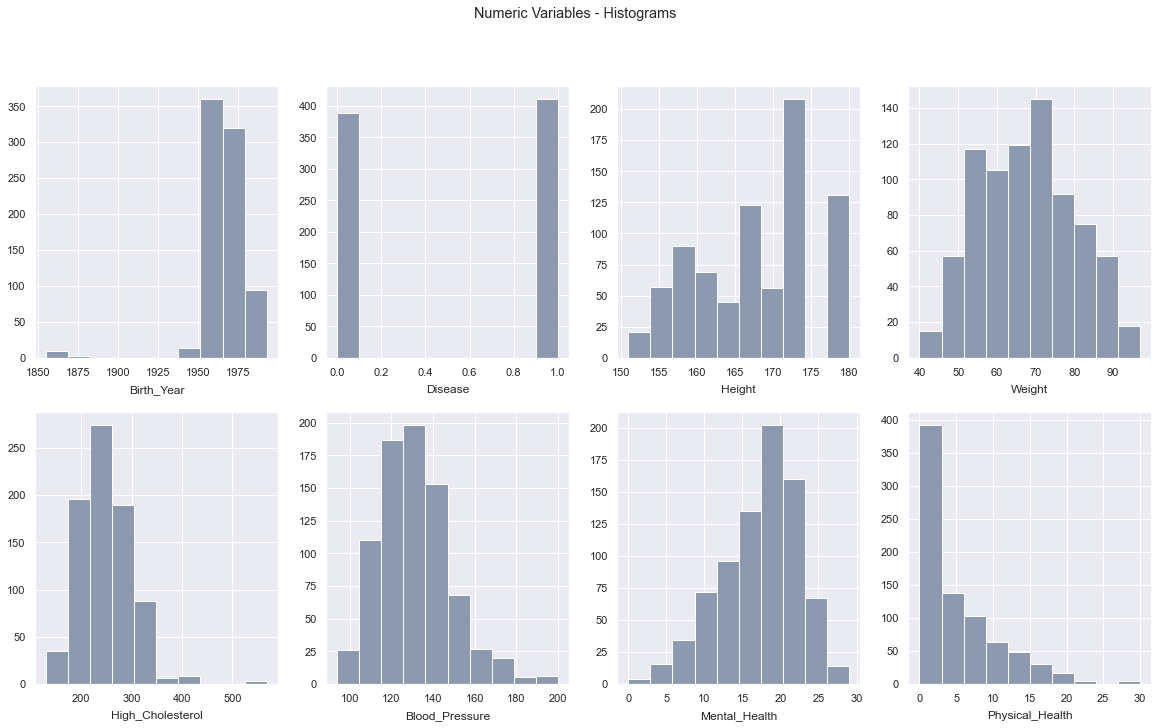

In [14]:
sns.set()

# preparing the figure by creating individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize = (20, 11))

# ploting the data
# iterating across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), metric_features):
    ax.hist(train[feat], bins = 10, color = '#8d99ae')
    ax.set_title(feat, y = -0.15)
    
# adding a centered title to the figure:
title = "Numeric Variables - Histograms"
plt.suptitle(title)

# showing the plot
plt.show()

And we can also plot all numeric variables' box plots in the same figure.

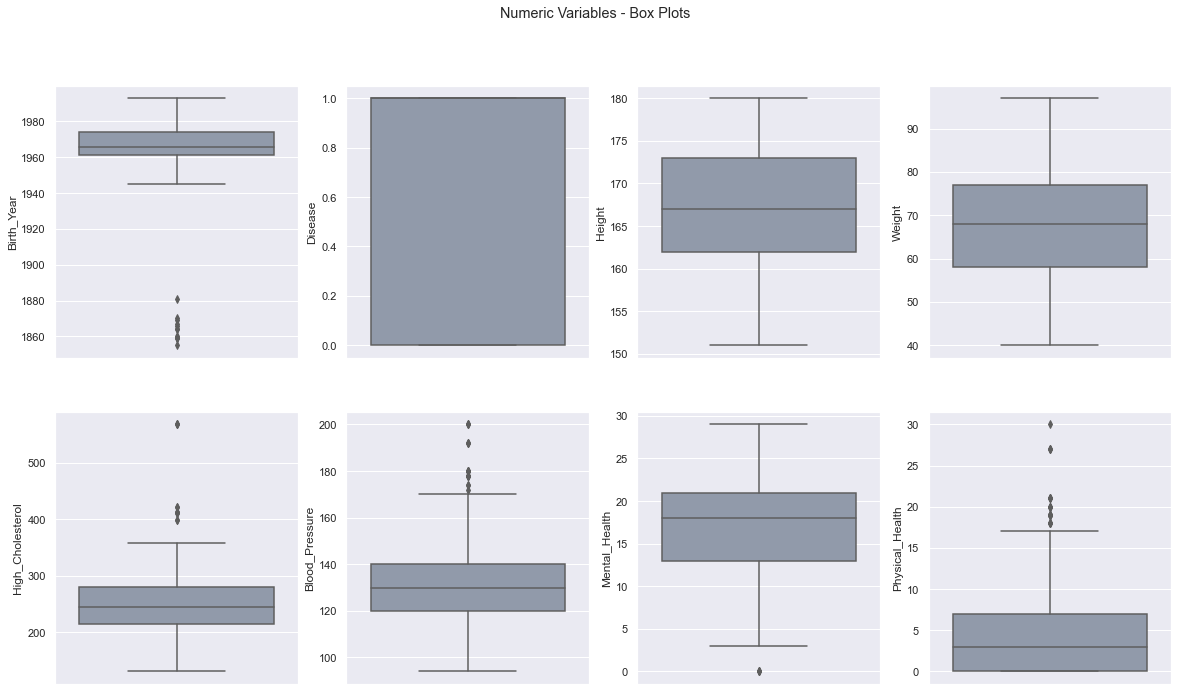

In [15]:
sns.set()

# preparing the figure by creating individual axes where each box-plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# ploting the data
# iterating across axes objects and associate each box-plot:
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(y = train[feat], ax = ax, color = '#8d99ae')

# adding a centered title to the figure:
title = "Numeric Variables - Box Plots"
plt.suptitle(title)

# showing the plot
plt.show()

For numerical variables we can still analyse the the relationship between all variables (to see some correlations, etc.).

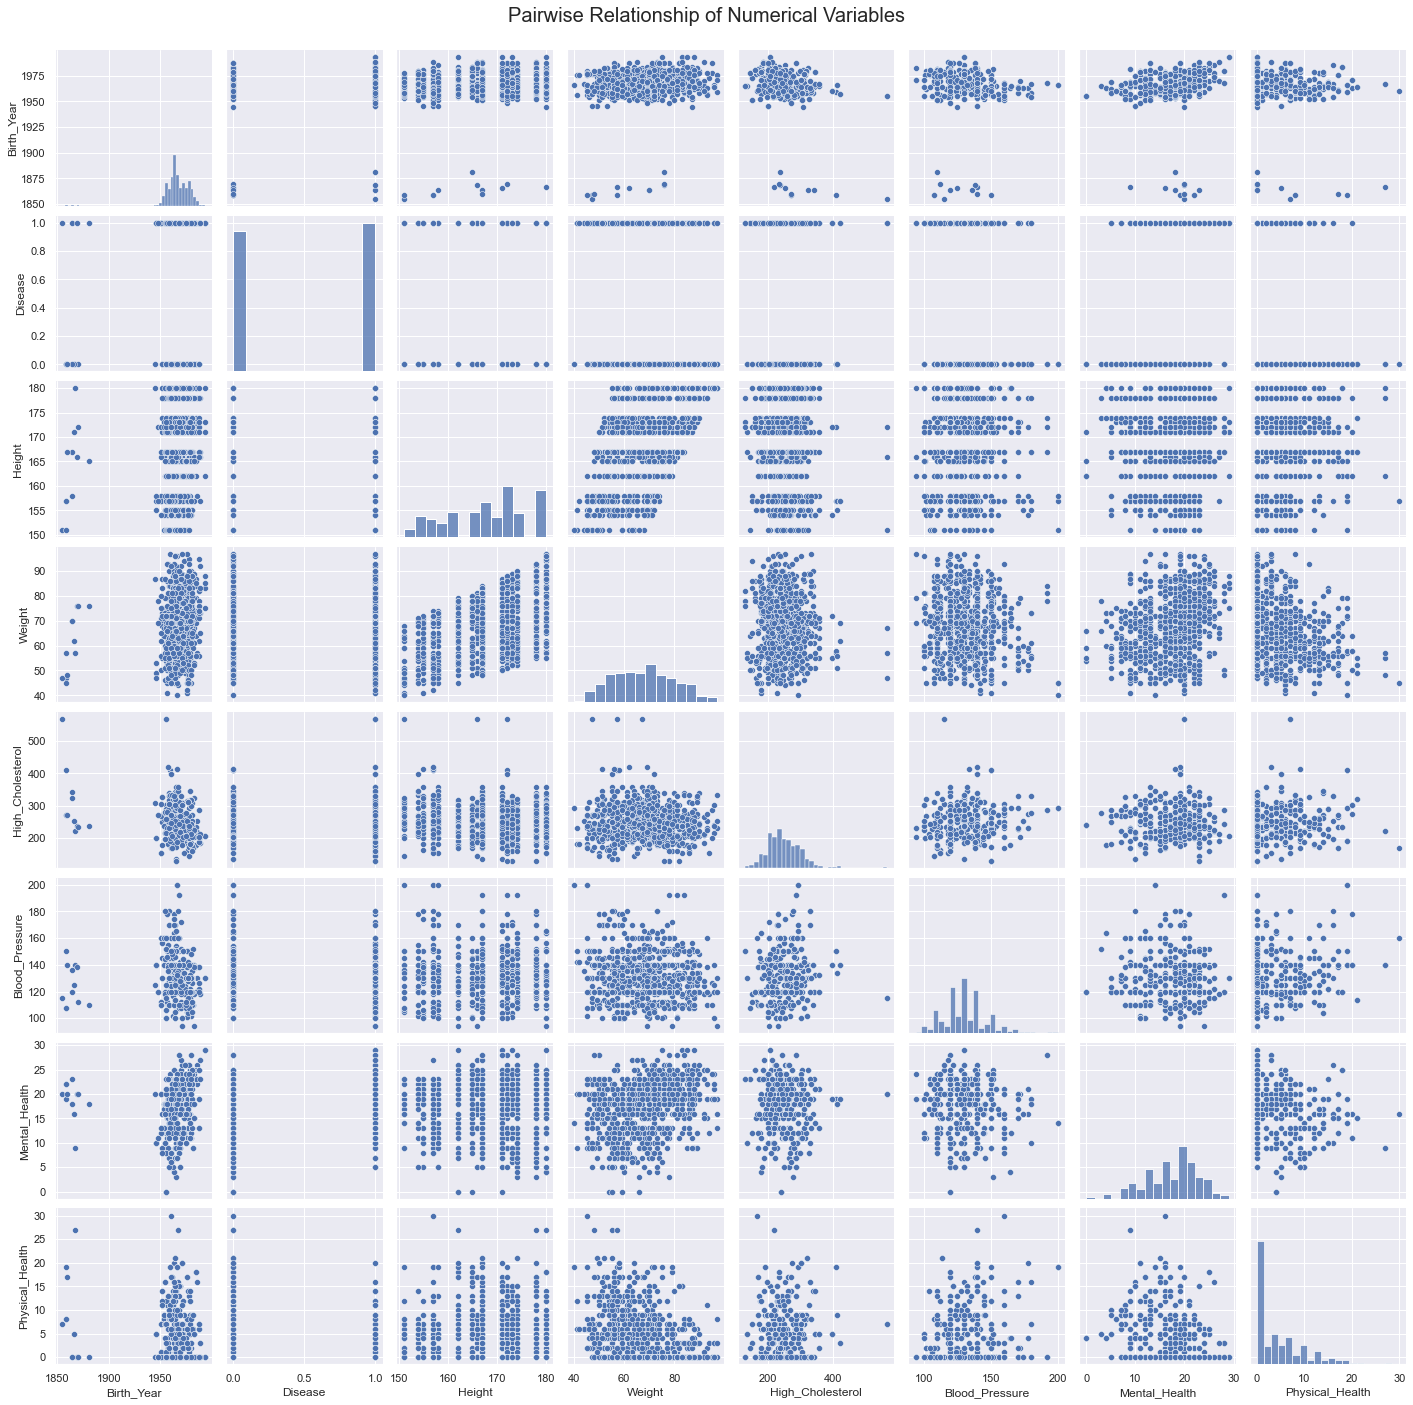

In [16]:
sns.set()

# setting pairplot, and in the diagonal of the figure the histograms already plotted before
sns.pairplot(train[metric_features])

# defining the layout
plt.subplots_adjust(top = 0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize = 20)

# showing the plot
plt.show()

Using the same logic from the multiple box plot figure above, we can build a multiple bar plot figure for each non-metric variable, in order to extract some useful information.

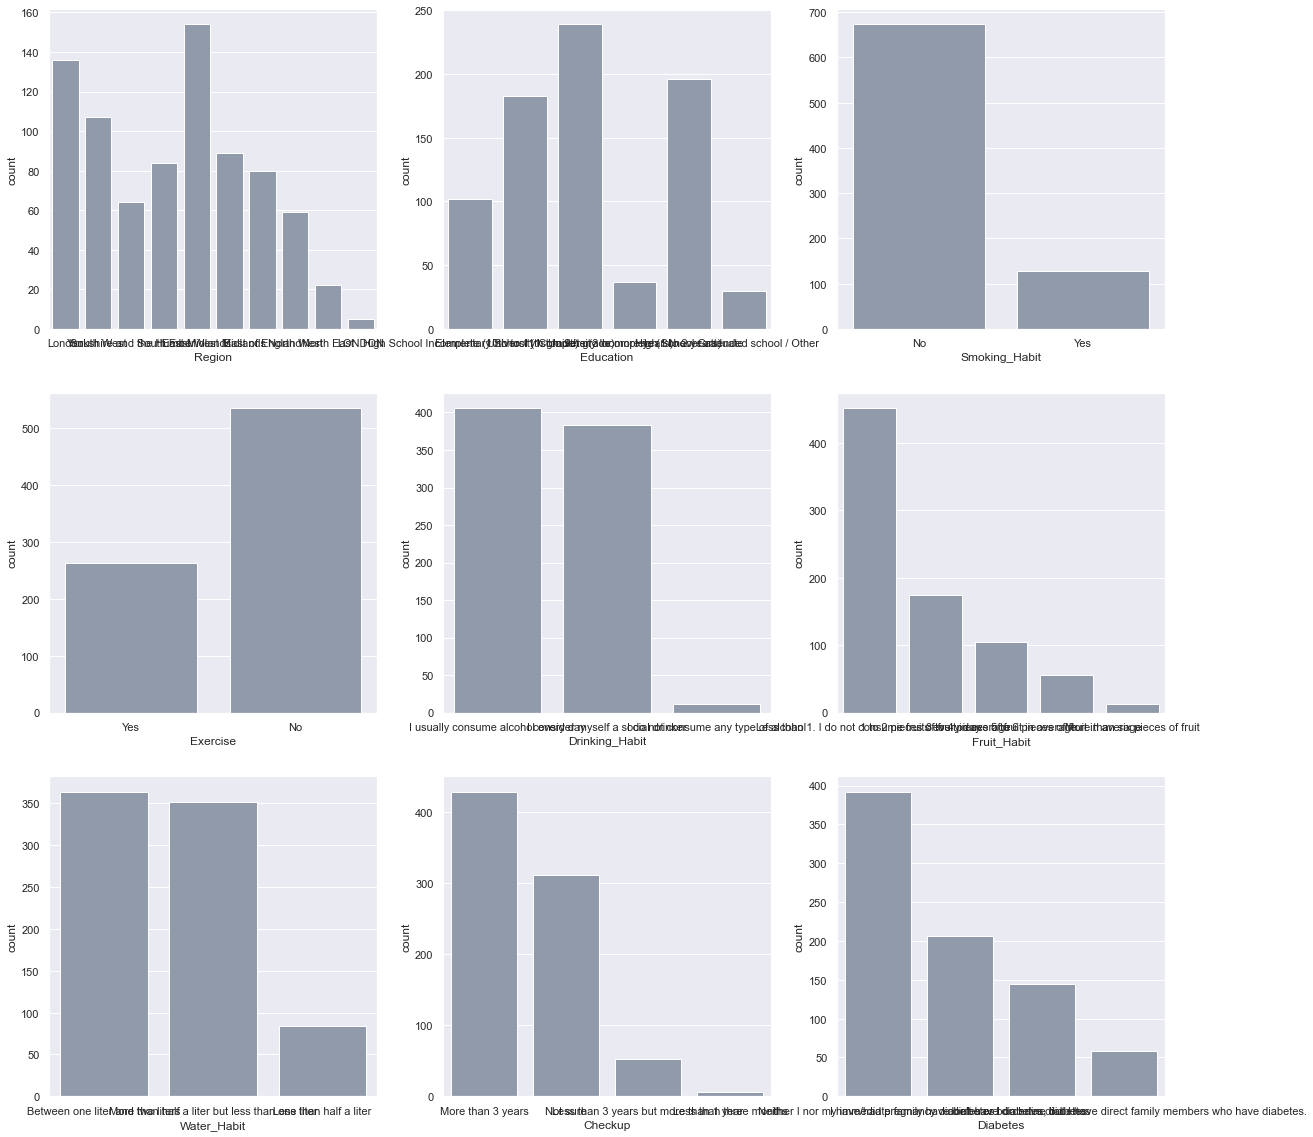

In [17]:
# we do not want to plot the Name variable in a boxplot, since it does not provide us any useful information
non_metric_features_name = non_metric_features.copy()
non_metric_features_name.remove('Name')

sns.set()

# preparing the figure by create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(non_metric_features_name) / 3), figsize = (20, 20))

# ploting the data
# iterating across axes objects and associating each box plot:
for ax, feat in zip(axes.flatten(), non_metric_features_name):
    sns.countplot(x = train[feat], color = '#8d99ae', ax = ax)
    
# showing the plot
plt.show()

From these bar charts, we can say that the majority of the patients in our training dataset does not smoke more than 10
cigars daily and does not exercise (more than 30 minutes) 3 times per week or more. Additionally, most of the patients did not make any check-up in the past 3 months.

Specifically looking at the `Region` bar chart, we can see that there is an inconsistency in the writting style of this variable, since London appears in two bars, one with a capital letter in the beggining of the word, and other with all capital letters.

Also, we can compare a categorical variable vs. a continuous variable. For example, we can compute the metric features and divide the observations according to one of the non metric features, like `Drinking_Habit`

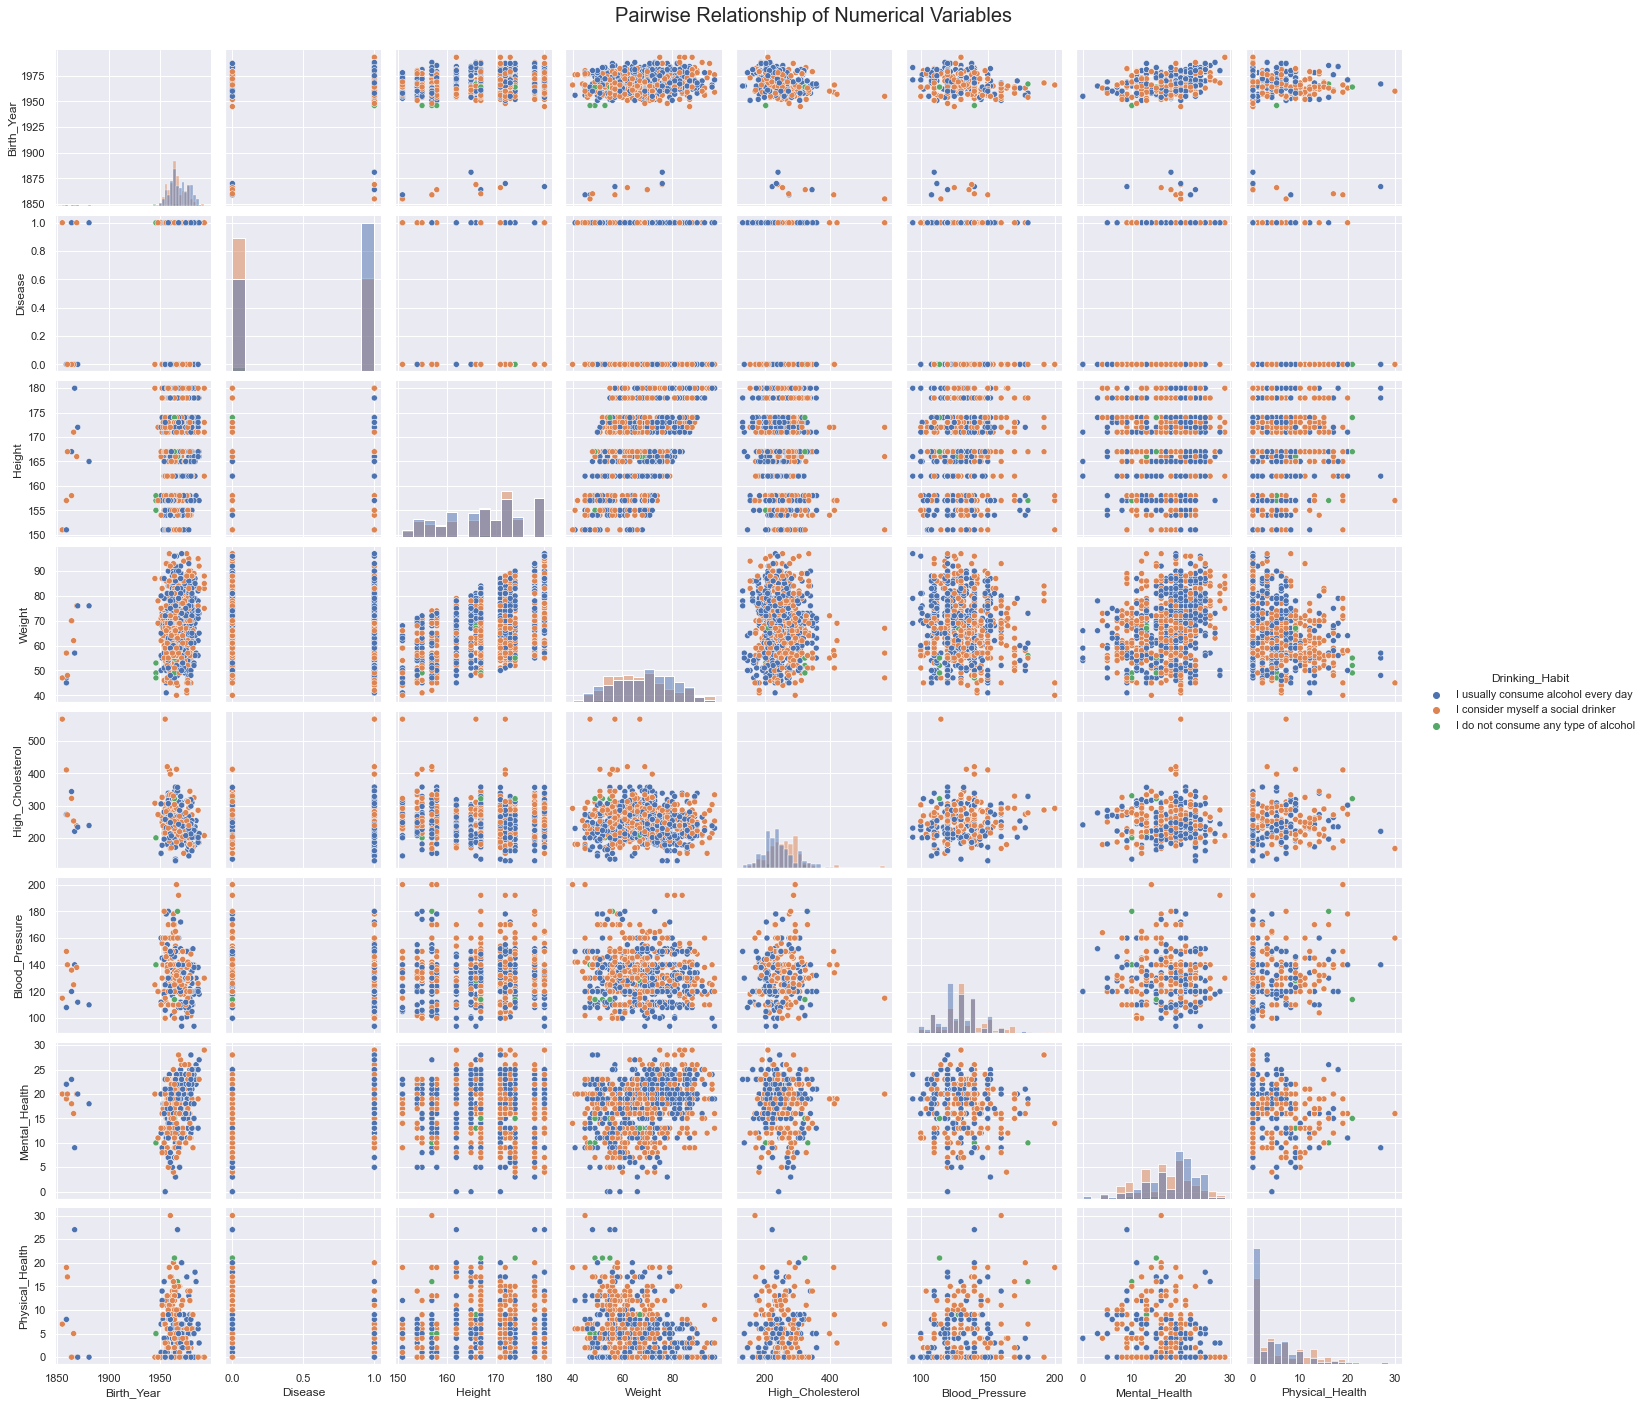

In [18]:
# pairwise relationship of numerical variables using a categorical variable hue
sns.set()

# setting pairplot
sns.pairplot(train[metric_features + ['Drinking_Habit']], diag_kind = "hist", hue = 'Drinking_Habit')

# layout
plt.subplots_adjust(top = 0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize = 20)

plt.show()

We should see how the variables behave when there is and isn't disease, as it is the main variable we want to predict

In [19]:
sns.set(style="whitegrid")

def box_plot_numerical(df, features, title):
    # Prepare figure
    fig, axes = plt.subplots(1, len(features), figsize=(20, 4), constrained_layout=True)

    # Plot data
    for ax, f in zip(axes.flatten(), features):
        sns.boxplot(y=f, data=df, ax=ax, x='Disease')
        ax.set_title(f)
        ax.set_ylabel('') 
        
    # Layout
    plt.suptitle(title, size=40)
    #plt.savefig(r'Figures\numeric_variables_boxplots2.png', dpi=200)
    plt.show()

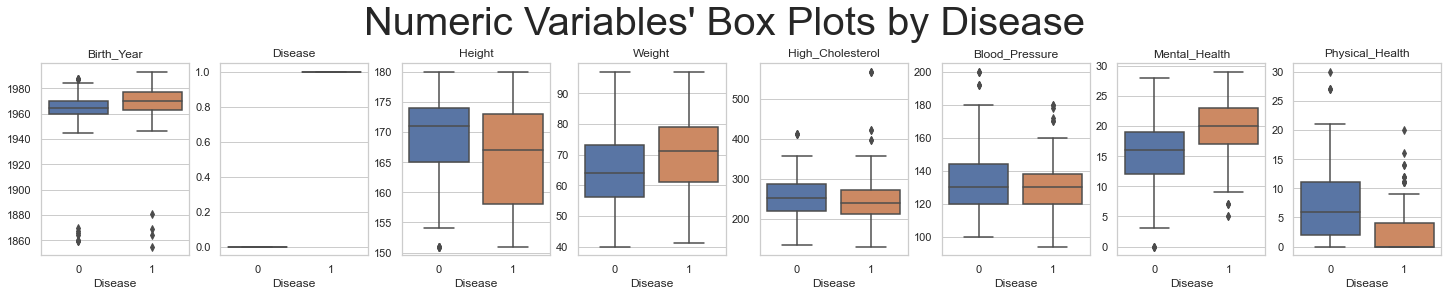

In [20]:
title = "Numeric Variables' Box Plots by Disease"

# features to plot
plot_features = metric_features

box_plot_numerical(train, plot_features, title)

In [21]:
sns.set(style="whitegrid")

def categorical_plot(df, features, title):
    # figure and axes
    fig, axes = plt.subplots(2, ceil(len(features)/2), figsize=(20,10))

    # plot data
    for ax, x in zip(axes.flatten(), features):
        if x == "Disease":
            sns.countplot(x=x, hue="Disease", order=[0, 1], data=df, ax=ax)
        else:
            sns.countplot(x=x, hue="Disease", data=df, ax=ax)
        ax.get_legend().remove()

    # Set legend (Deceased)
    handles, _ = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, ["No Disease", "Disease"], loc=(0.07,0.91), title="Disease", title_fontsize=12)

    plt.subplots_adjust(wspace=0.25)
    plt.suptitle(title, y=0.95, size=40)
    #plt.savefig(r'Figures\categorical_variables_abs_frequencies.png', dpi=200)
    plt.show()

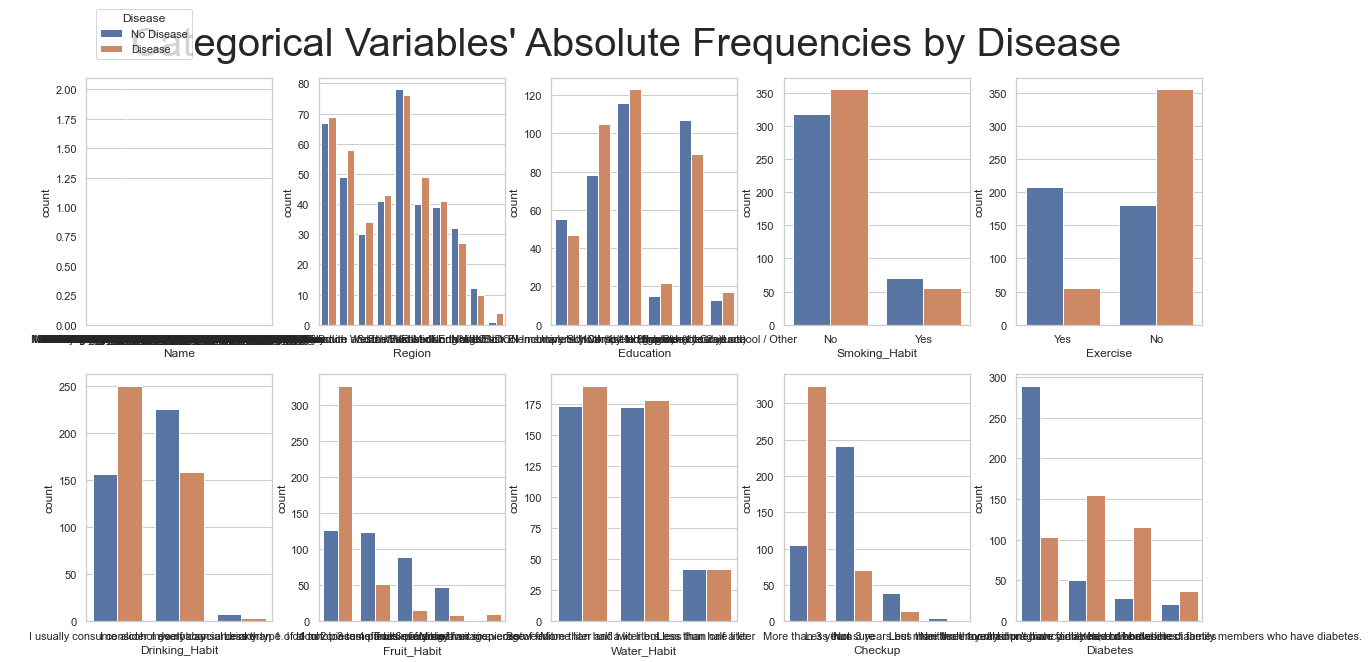

In [22]:
title = "Categorical Variables' Absolute Frequencies by Disease"
# data to plot
plot_df = train
plot_features = non_metric_features

categorical_plot(plot_df, plot_features, title)

<div class="alert alert-block alert-success"> 
    
## 3. Preprocessing

### Problems:
- Duplicates?
- New features?
- Data types?
- Missing values?
- Strange values?
- Descriptive statistics?

### 3.1. Duplicates

In [23]:
# checking duplicate observations

train.duplicated().sum()

0

As we saw before there were no duplicate observations.

### 3.2. New features

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1167 to 1117
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              800 non-null    object
 1   Birth_Year        800 non-null    int64 
 2   Region            800 non-null    object
 3   Education         787 non-null    object
 4   Disease           800 non-null    int64 
 5   Smoking_Habit     800 non-null    object
 6   Drinking_Habit    800 non-null    object
 7   Exercise          800 non-null    object
 8   Fruit_Habit       800 non-null    object
 9   Water_Habit       800 non-null    object
 10  Height            800 non-null    int64 
 11  Weight            800 non-null    int64 
 12  High_Cholesterol  800 non-null    int64 
 13  Blood_Pressure    800 non-null    int64 
 14  Mental_Health     800 non-null    int64 
 15  Physical_Health   800 non-null    int64 
 16  Checkup           800 non-null    object
 17  Diabetes    

In [25]:
# creating a variable 'Age' based on 'Birth_Year'

train['Age'] = date.today().year - train['Birth_Year']

In [26]:
# creating a variable 'Gender' based on the presence of Mrs. or Mr. in the variable 'Name'

males = train['Name'].str.contains('Mr\.')
females = train['Name'].str.contains('Mrs\.')

# the 'Gender' variable is 1 if the patient is Male, and 0 is the patient is Female
train['Gender'] = males.astype(int)

In [27]:
#creating variable BMI
train['BMI'] = train['Weight']/(train['Height']**2)

In [28]:
#days in the year/percentage w mental health or physical health
#diabetes yes or no

### 3.3. Missing values

As we saw before, there are missing values (NaN) in the variable `Education`. We can check if there are missing values encoded as empty strings, by setting them to NaN and then counting the total of NaN in each variable.

In [29]:
# replace "" by nans (inplace saves it into the original database)
train.replace("", np.nan, inplace = True)

# count of missing values
train.isna().sum()

Name                 0
Birth_Year           0
Region               0
Education           13
Disease              0
Smoking_Habit        0
Drinking_Habit       0
Exercise             0
Fruit_Habit          0
Water_Habit          0
Height               0
Weight               0
High_Cholesterol     0
Blood_Pressure       0
Mental_Health        0
Physical_Health      0
Checkup              0
Diabetes             0
Age                  0
Gender               0
BMI                  0
dtype: int64

Since we do not want to use any information from the validation dataset in our training dataset (to make sure that the validation dataset is not seen by our model in the learning phase), we should start by splitting the training dataset into two, the training and the validation dataset.

In [30]:
# creating an object named data that will contain the independent variables and another object named target that will contain
# the dependent variable/target, in this case 'Disease'.

data = train.drop('Disease', axis = 1)
target = train['Disease']

In [31]:
# dividing the data into X_train and X_val, the target into y_train and y_val

X_train, X_val, y_train, y_val = train_test_split(data, target, test_size = 0.15, stratify = target, random_state = 5)

So, we are in conditions to fill the missing values in X_train and in X_val.

In [32]:
# creating a copy of the dataset to apply central tendency measures imputation

X_train_central = X_train.copy()

In [33]:
# calculating the mode of the variable 'Education' to use it to fill the missing values

mode_education = X_train_central['Education'].mode().loc[0]

In [34]:
# filling the missing values (inplace = True to save the changes directly in the dataset)

X_train_central.fillna(mode_education, inplace = True)

In [35]:
# checking how many NaNs we still have

X_train_central.isna().sum()

Name                0
Birth_Year          0
Region              0
Education           0
Smoking_Habit       0
Drinking_Habit      0
Exercise            0
Fruit_Habit         0
Water_Habit         0
Height              0
Weight              0
High_Cholesterol    0
Blood_Pressure      0
Mental_Health       0
Physical_Health     0
Checkup             0
Diabetes            0
Age                 0
Gender              0
BMI                 0
dtype: int64

"As a general rule of thumb, only features that are missing in excess of 60% of their values should be considered for complete removal, so, in this case, we should not remove the observations" (*Fundamentals of Machine Learning for Predictive Data Analytics Algorithms*). In the other hand, the 13 observations with missing values represent 1.625% of the training dataset, so deleting them should not be problematic.

In [36]:
# creating a copy of the dataset to delete the missing values

X_train_delete = X_train.copy()

In [37]:
# deleting the observations that contain missing values (inplace = True to save the changes directly in the dataset)

X_train_delete.dropna(inplace = True)

"There are other, more complex approaches to imputation. For example, we can actually build a predictive model that estimates a replacement for a missing value based on the feature values that are present in a dataset for a given instance." (*Fundamentals of Machine Learning for Predictive Data Analytics Algorithms*)

### 3.4. Data types

In [38]:
# converting to 1 or 0 (Yes or No) the variable Smoking_Habit and Exercise

train['Smoking_Habit'] = train['Smoking_Habit'].map({'Yes': 1, 'No': 0})
train['Exercise'] = train['Exercise'].map({'Yes': 1, 'No': 0})

In [39]:
# one-hot encoding to the categorical variables


### 3.5. Descriptive statistics

### 3.6. Strange values

In [40]:
X_train.head()

,Name,Birth_Year,Region,Education,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes,Age,Gender,BMI
PatientID,,,,,,,,,,,,,,,,,,,,
1702,Mrs. Cheryl Dobkowski,1951,South East,Elementary School (1st to 9th grade),No,I usually consume alcohol every day,No,3 to 4 pieces of fruit in average,More than half a liter but less than one liter,167,80,306,160,20,1,More than 3 years,I do have diabetes,71,0,0.002869
1395,Mrs. Jennifer Blair,1956,North West,Elementary School (1st to 9th grade),No,I consider myself a social drinker,No,1 to 2 pieces of fruit in average,Between one liter and two liters,167,66,282,146,18,0,More than 3 years,I have/had pregnancy diabetes or borderline di...,66,0,0.002367
1802,Mrs. Mary Rey,1959,South West,NaN,No,I usually consume alcohol every day,Yes,Less than 1. I do not consume fruits every day.,Between one liter and two liters,151,47,201,124,14,0,More than 3 years,Neither I nor my immediate family have diabetes.,63,0,0.002061
1907,Mrs. Anita Higgin,1972,London,High School Incomplete (10th to 11th grade),No,I usually consume alcohol every day,No,Less than 1. I do not consume fruits every day.,More than half a liter but less than one liter,154,70,248,120,20,5,More than 3 years,I do have diabetes,50,0,0.002952
1845,Mr. Irwin Mcclure,1966,East Midlands,Elementary School (1st to 9th grade),No,I consider myself a social drinker,Yes,1 to 2 pieces of fruit in average,Less than half a liter,173,56,188,132,7,10,Less than 3 years but more than 1 year,Neither I nor my immediate family have diabetes.,56,1,0.001871


In [41]:
train['Name'].value_counts()

Mr. Gary Miller           2
Mrs. Stephanie Gay        1
Mr. Roger Rudd            1
Mr. Vito Ertz             1
Mrs. Marilyn Miller       1
                         ..
Mr. Dennis Chatcho        1
Mrs. Shirley Thomas       1
Mr. Martin Paine          1
Mr. Tommy Tricomi         1
Mr. Freddie Vermillion    1
Name: Name, Length: 799, dtype: int64

In [42]:
train['Birth_Year'].value_counts().sort_index(ascending=True)

1855     1
1859     3
1860     1
1864     2
1866     1
1867     1
1869     1
1870     1
1881     1
1945     1
1946     3
1948     2
1951     8
1952     9
1953     7
1954    11
1955    24
1956    21
1957    19
1958    27
1959    19
1960    29
1961    23
1962    29
1963    38
1964    57
1965    47
1966    31
1967    19
1968    37
1969    19
1970    31
1971    31
1972    19
1973    15
1974    17
1975    15
1976    17
1977    21
1978    26
1979    22
1980    22
1981    25
1982     7
1983     9
1984     9
1985     2
1987    12
1988     4
1993     4
Name: Birth_Year, dtype: int64

In [43]:
train['Region'].value_counts()

East Midlands               154
London                      136
South West                  107
West Midlands                89
South East                   84
East of England              80
Yorkshire and the Humber     64
North West                   59
North East                   22
LONDON                        5
Name: Region, dtype: int64

In [44]:
#Fixing the LONDON because it should be the same as London
train['Region'] = train['Region'].str.replace('London', "London", case=False)

In [45]:
train['Region'].value_counts()

East Midlands               154
London                      141
South West                  107
West Midlands                89
South East                   84
East of England              80
Yorkshire and the Humber     64
North West                   59
North East                   22
Name: Region, dtype: int64

In [46]:
train['Education'].value_counts()

University Complete (3 or more years)          239
High School Graduate                           196
Elementary School (1st to 9th grade)           183
High School Incomplete (10th to 11th grade)    102
University Incomplete (1 to 2 years)            37
I never attended school / Other                 30
Name: Education, dtype: int64

In [47]:
train['Disease'].value_counts()

1    411
0    389
Name: Disease, dtype: int64

In [48]:
train['Smoking_Habit'].value_counts()

0    673
1    127
Name: Smoking_Habit, dtype: int64

In [49]:
train['Drinking_Habit'].value_counts()

I usually consume alcohol every day     406
I consider myself a social drinker      383
I do not consume any type of alcohol     11
Name: Drinking_Habit, dtype: int64

In [50]:
train['Exercise'].value_counts()

0    536
1    264
Name: Exercise, dtype: int64

In [51]:
train['Fruit_Habit'].value_counts()

Less than 1. I do not consume fruits every day.    452
1 to 2 pieces of fruit in average                  175
3 to 4 pieces of fruit in average                  105
5 to 6 pieces of fruit in average                   56
More than six pieces of fruit                       12
Name: Fruit_Habit, dtype: int64

In [52]:
train['Water_Habit'].value_counts()

Between one liter and two liters                  364
More than half a liter but less than one liter    352
Less than half a liter                             84
Name: Water_Habit, dtype: int64

In [53]:
train['Height'].value_counts().sort_index(ascending=True)

151    21
154    26
155    31
157    51
158    39
162    69
165    45
166    25
167    98
171    56
172    81
173    61
174    66
178    74
180    57
Name: Height, dtype: int64

In [54]:
train['Weight'].value_counts().sort_index(ascending=True)

40     1
41     2
42     1
44     1
45    10
46     5
47     8
48     8
49     9
50    13
51    14
52    16
53    11
54    21
55    23
56    24
57    22
58    13
59    29
60    17
61    26
62    20
63    19
64    18
65    18
66    18
67    24
68    22
69    23
70    32
71    26
72    26
73    20
74    18
75    17
76    22
77    14
78    22
79    17
80    14
81    17
82    12
83    13
84    11
85     8
86    16
87    14
88    12
89     9
90     6
92     4
93     4
94     1
95     2
96     4
97     3
Name: Weight, dtype: int64

In [55]:
train['High_Cholesterol'].value_counts().sort_index(ascending=True)

#High cholesterol is only above 200? and above 300 is very rare

130    3
135    2
145    3
153    6
161    4
      ..
398    2
411    2
413    2
421    2
568    3
Name: High_Cholesterol, Length: 150, dtype: int64

In [56]:
train['Blood_Pressure'].value_counts().sort_index(ascending=True)

94       3
100     13
101      3
102      5
104      2
105      7
106      3
108     15
110     50
112     23
114      4
115      8
117      4
118     15
120    111
122     13
123      3
124     15
125     26
126      8
128     33
129      3
130     95
132     23
134     13
135     16
136      7
138     33
140     86
142      9
144      5
145     12
146      8
148      6
150     42
152     11
154      3
155      3
156      3
160     20
164      3
165      4
170     12
172      1
174      2
178      5
180      5
192      3
200      3
Name: Blood_Pressure, dtype: int64

In [57]:
train['Mental_Health'].value_counts().sort_index(ascending=True)

0      4
3      2
4      3
5     11
6      3
7     16
8     15
9     26
10    19
11    27
12    33
13    49
14    14
15    31
16    68
17    36
18    56
19    65
20    81
21    52
22    49
23    59
24    31
25    24
26    12
27     4
28     6
29     4
Name: Mental_Health, dtype: int64

In [58]:
train['Physical_Health'].value_counts().sort_index(ascending=True)

0     311
1      30
2      51
3      34
4      51
5      53
6      36
7      40
8      27
9      38
10     14
11     12
12     19
13     17
14     12
15     10
16      7
17     13
18      4
19      9
20      4
21      4
27      3
30      1
Name: Physical_Health, dtype: int64

In [59]:
train['Checkup'].value_counts()

More than 3 years                         429
Not sure                                  312
Less than 3 years but more than 1 year     53
Less than three months                      6
Name: Checkup, dtype: int64

In [60]:
train['Diabetes'].value_counts()

Neither I nor my immediate family have diabetes.                              392
I have/had pregnancy diabetes or borderline diabetes                          206
I do have diabetes                                                            144
I don't have diabetes, but I have direct family members who have diabetes.     58
Name: Diabetes, dtype: int64

### Outlier removal

In [61]:
# creating a copy to apply the methods for outlier removal

train_outlier = train.copy()

#### IQR method

In [62]:
# calculating the quartiles and the correspondent inter quartil range

q25 = train_outlier.quantile(.25)
q75 = train_outlier.quantile(.75)
iqr = (q75 - q25)

In [63]:
# defining the limits to search for outliers

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

In [64]:
# applying the calculated measures to filter the observations in our dataset and transforming the result into a pandas series

filter1 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filter1.append(train_outlier[metric].between(llim, ulim, inclusive = 'both'))
filter1 = pd.Series(np.all(filter1, 0), index = train.index)

In [65]:
# applying the filter to our dataframe

train_filter1 = train_outlier[filter1]
print('Percentage of data kept after removing outliers:', np.round(train_filter1.shape[0] / train.shape[0] * 100, 4))

Percentage of data kept after removing outliers: 92.25


#### Manual

In [66]:
filter2 = (
    (train_outlier['Birth_Year'] >= 1890)
    &
    (train_outlier['High_Cholesterol'] <= 380)
    &
    (train_outlier['Blood_Pressure'] <= 170)
    &
    (train_outlier['Mental_Health'] >= 3)
    &
    (train_outlier['Physical_Health'] <= 17)
   
)

In [67]:
train_filter2 = train_outlier[filter2]
print('Percentage of data kept after removing outliers:', np.round(train_filter2.shape[0] / train.shape[0] * 100, 4))

Percentage of data kept after removing outliers: 92.25


In [68]:
train_filter2.shape[0]

738

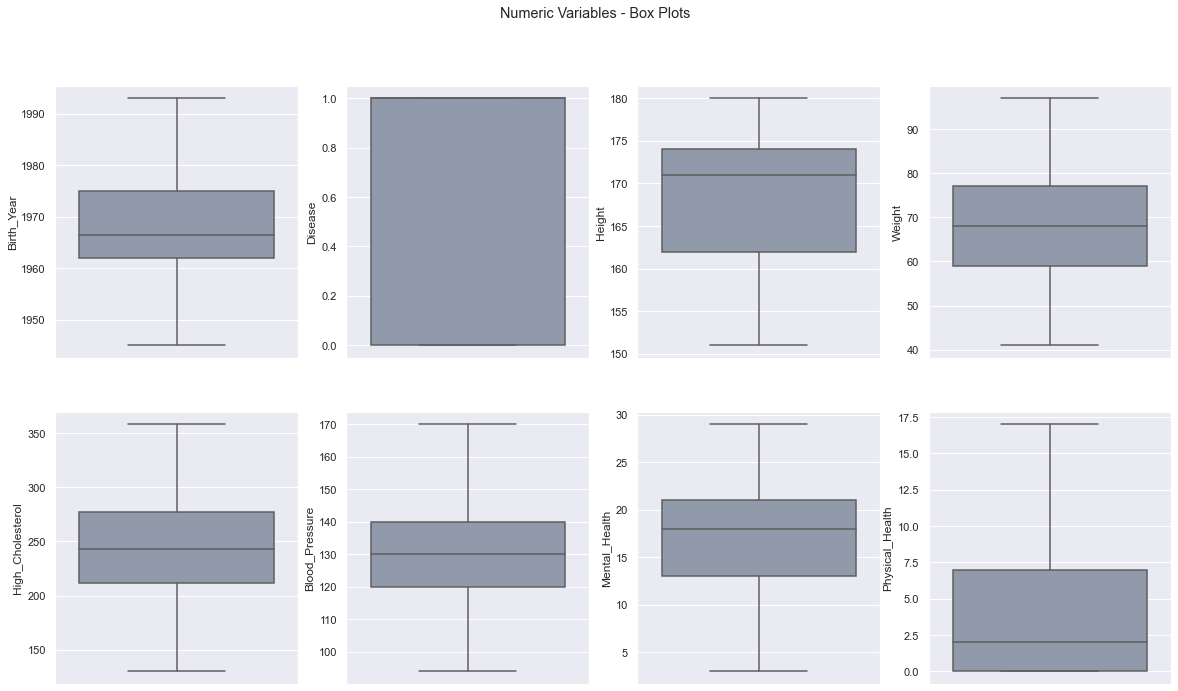

In [69]:
sns.set()

# preparing the figure by creating individual axes where each box-plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# ploting the data
# iterating across axes objects and associate each box-plot:
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(y = train_filter2[feat], ax = ax, color = '#8d99ae')

# adding a centered title to the figure:
title = "Numeric Variables - Box Plots"
plt.suptitle(title)

# showing the plot
plt.show()

In [70]:
train_filter3 = train_outlier[(filter1 | filter2)]
print('Percentage of data kept after removing outliers:', np.round(train_filter3.shape[0] / train.shape[0] * 100, 4))

Percentage of data kept after removing outliers: 92.25


<div class="alert alert-block alert-success"> 
    
## FEATURE Engineering/Selection


### Encoding


In [ ]:
#Nao é so aqui que deviamos fazer isto??

# converting to 1 or 0 (Yes or No) the variable Smoking_Habit and Exercise

#train['Smoking_Habit'] = train['Smoking_Habit'].map({'Yes': 1, 'No': 0})
#train['Exercise'] = train['Exercise'].map({'Yes': 1, 'No': 0})

In [112]:
# one-hot encoding to the categorical variables
#like Region
train_encoder = train.copy()

In [113]:
#ordinal enconding for ordinal variables
#like Education and Water Habit as they can have an order of greater or less??
oe= OrdinalEncoder()



In [114]:
#def num_or_cat(data):
    
    #data_num = data[data.select_dtypes(include=np.number).columns.tolist()]
    #data_cat = data.drop(data_num, axis=1)
    #return data_num, data_cat

#data_train_num, data_train_cat = num_or_cat(df_extract)

numerical = list(X_train_num.columns)
categorical = list(X_train_cat.columns)

In [115]:
oe = OrdinalEncoder()
oe_feat = oe.fit_transform(train_encoder[categorical]) #da um numpy array
oe_train = pd.DataFrame(oe_feat, index=train_encoder.index, columns=categorical)
train_encoder[categorical] = oe_train

In [117]:
train_encoder.head()

,Name,Birth_Year,Region,Education,Disease,Smoking_Habit,Drinking_Habit,Exercise,Fruit_Habit,Water_Habit,...,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Checkup,Diabetes,Age,Gender,BMI
PatientID,,,,,,,,,,,,,,,,,,,,,
1167,775.0,1965,2.0,2.0,1,0.0,2.0,1.0,3.0,0.0,...,67,358,120,21,2,2.0,3.0,57,0,0.002789
1805,500.0,1969,6.0,2.0,1,0.0,0.0,1.0,3.0,0.0,...,88,230,142,9,0,3.0,3.0,53,1,0.002940
1557,354.0,1974,8.0,0.0,1,0.0,0.0,0.0,3.0,2.0,...,68,226,122,26,0,2.0,3.0,48,1,0.002591
1658,101.0,1958,2.0,4.0,0,0.0,2.0,1.0,3.0,2.0,...,66,313,125,13,8,3.0,2.0,64,1,0.002037
1544,187.0,1968,5.0,5.0,1,0.0,0.0,0.0,0.0,2.0,...,58,277,125,18,2,2.0,2.0,54,1,0.001790


In [120]:
train["Education"].value_counts()

University Complete (3 or more years)          239
High School Graduate                           196
Elementary School (1st to 9th grade)           183
High School Incomplete (10th to 11th grade)    102
University Incomplete (1 to 2 years)            37
I never attended school / Other                 30
Name: Education, dtype: int64

In [119]:
train_encoder["Education"].value_counts()

4.0    239
1.0    196
0.0    183
2.0    102
5.0     37
3.0     30
Name: Education, dtype: int64

In [ ]:
#está errado

In [121]:
train["Water_Habit"].value_counts()

Between one liter and two liters                  364
More than half a liter but less than one liter    352
Less than half a liter                             84
Name: Water_Habit, dtype: int64

In [122]:
train_encoder["Water_Habit"].value_counts()

0.0    364
2.0    352
1.0     84
Name: Water_Habit, dtype: int64


### Normalization


In [71]:
# Depending on the feature selection technique used, the input variables can differ - some techniques work only with 
# numerical variables while others with categorical data. Define a new object named a X_train_num where only the numerical 
# variables are mantained, and a object named as X_train_cat with all the categorical independent variables.

X_train_num = X_train.select_dtype
### Univariate variables
s(include = np.number).set_index(X_train.index)
X_train_cat = X_train.select_dtypes(exclude = np.number).set_index(X_train.index)
X_val_num = X_val.select_dtypes(include = np.number).set_index(X_val.index)
X_val_cat = X_val.select_dtypes(exclude = np.number).set_index(X_val.index)

The MinMaxScaler estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

In [72]:
# Scale the numerical variables
# MinMaxScaler: new_x = (old_x - x_min) / (x_max - x_min)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num) # this will return an array
# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)
X_train_num_scaled.head(3)

,Birth_Year,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Age,Gender,BMI
PatientID,,,,,,,,,,
1702,0.695652,0.551724,0.701754,0.401826,0.622642,0.689655,0.033333,0.304348,0.0,0.890882
1395,0.731884,0.551724,0.456140,0.347032,0.490566,0.620690,0.000000,0.268116,0.0,0.508969
1802,0.753623,0.000000,0.122807,0.162100,0.283019,0.482759,0.000000,0.246377,0.0,0.276765


In [73]:
# the scaling should also consider only the training data. In that way, we are going to use the minimum and maximum values
# of the training dataset for each variable (the MinMaxScaler use those values to scale the data) to scale also the
# validation dataset.

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)
X_val_num_scaled.head(3)

,Birth_Year,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Age,Gender,BMI
PatientID,,,,,,,,,,
1663,0.789855,0.137931,0.333333,0.278539,0.056604,0.379310,0.133333,0.210145,0.0,0.576871
1214,0.884058,0.793103,0.859649,0.415525,0.320755,0.758621,0.000000,0.115942,1.0,0.944981
1378,0.724638,0.689655,0.456140,0.253425,0.245283,0.000000,0.133333,0.275362,1.0,0.425723


Looking at the High_Cholesterol maximum value, we can see that it is far away from the third quartile, so probabily we are in the presence of an outlier (maybe error of measurment, since the normal range of the cholesterol in blood is 120-150).


# Selection


## Filter methods
    
</a>


### Univariate variables


In [74]:
X_train_num_scaled.var()

Birth_Year          0.013800
Height              0.076054
Weight              0.045178
High_Cholesterol    0.014336
Blood_Pressure      0.025781
Mental_Health       0.033983
Physical_Health     0.033520
Age                 0.013800
Gender              0.210309
BMI                 0.078044
dtype: float64

There is no univariate variable so we don't need to drop any variable


### Spearman Correlation


In [75]:
#we need to create a new dataframe with all the training data, but containing also the dependent variable, 
#so we can check if any of the independent variables are correlated with the target.

all_train_num = X_train_num_scaled.join(y_train)
all_train_num.head()

,Birth_Year,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Age,Gender,BMI,Disease
PatientID,,,,,,,,,,,
1702,0.695652,0.551724,0.701754,0.401826,0.622642,0.689655,0.033333,0.304348,0.0,0.890882,1
1395,0.731884,0.551724,0.456140,0.347032,0.490566,0.620690,0.000000,0.268116,0.0,0.508969,1
1802,0.753623,0.000000,0.122807,0.162100,0.283019,0.482759,0.000000,0.246377,0.0,0.276765,0
1907,0.847826,0.103448,0.526316,0.269406,0.245283,0.689655,0.166667,0.152174,0.0,0.954089,1
1845,0.804348,0.758621,0.280702,0.132420,0.358491,0.241379,0.333333,0.195652,1.0,0.132047,0


In [76]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [77]:
#Check the spearman correlation of the all_train dataset
cor_spearman = all_train_num.corr(method ='spearman')
cor_spearman

,Birth_Year,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Age,Gender,BMI,Disease
Birth_Year,1.000000,0.052874,0.174931,-0.223178,-0.254442,0.359210,-0.237125,-1.000000,0.126904,0.161735,0.229281
Height,0.052874,1.000000,0.476497,-0.049088,-0.009968,-0.053634,0.057188,-0.052874,0.645135,-0.022087,-0.145918
Weight,0.174931,0.476497,1.000000,-0.038410,-0.066055,0.333801,-0.449187,-0.174931,0.335360,0.850509,0.194257
High_Cholesterol,-0.223178,-0.049088,-0.038410,1.000000,0.130722,-0.020941,0.028894,0.223178,-0.166554,0.008014,-0.120933
Blood_Pressure,-0.254442,-0.009968,-0.066055,0.130722,1.000000,-0.038049,0.108971,0.254442,-0.080370,-0.086872,-0.111446
Mental_Health,0.359210,-0.053634,0.333801,-0.020941,-0.038049,1.000000,-0.420424,-0.359210,-0.053198,0.399132,0.411366
Physical_Health,-0.237125,0.057188,-0.449187,0.028894,0.108971,-0.420424,1.000000,0.237125,0.083670,-0.546178,-0.446981
Age,-1.000000,-0.052874,-0.174931,0.223178,0.254442,-0.359210,0.237125,1.000000,-0.126904,-0.161735,-0.229281
Gender,0.126904,0.645135,0.335360,-0.166554,-0.080370,-0.053198,0.083670,-0.126904,1.000000,-0.010111,-0.310106
BMI,0.161735,-0.022087,0.850509,0.008014,-0.086872,0.399132,-0.546178,-0.161735,-0.010111,1.000000,0.310682


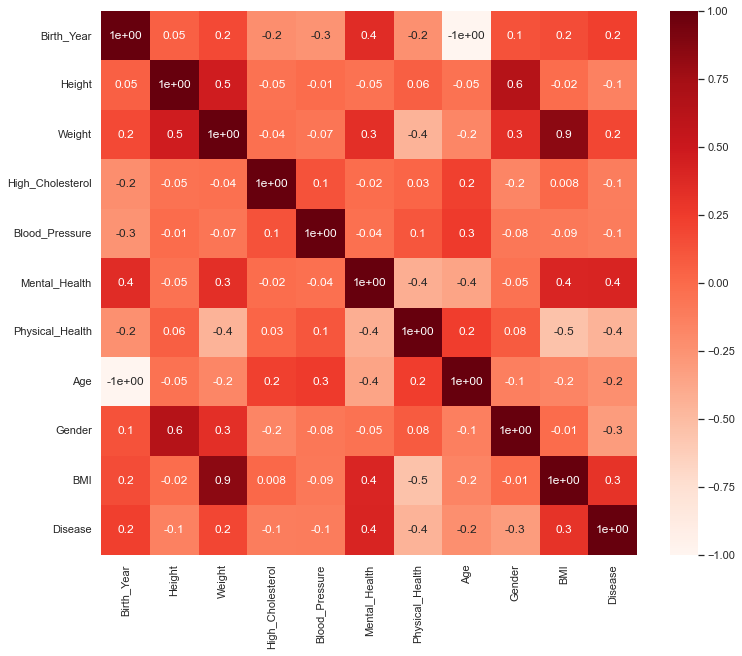

In [78]:
cor_heatmap(cor_spearman)

We can conclude that:
- There is no independent variable highly correlated with the target. We need to use other feature selection techniques to get more insights.
- There are two pairs of variables highly correlated, namely:
    - Height vs Gender (0.6) <br>
    - BMI vs Weight (0.9) <br>

We need to use other techniques of feature selection to decide which variables should we keep.


### Chi-Square for categorical data


In [79]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [80]:
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

Name is NOT an important predictor. (Discard Name from model)
Region is NOT an important predictor. (Discard Region from model)
Education is NOT an important predictor. (Discard Education from model)
Smoking_Habit is NOT an important predictor. (Discard Smoking_Habit from model)
Drinking_Habit is IMPORTANT for Prediction
Exercise is IMPORTANT for Prediction
Fruit_Habit is IMPORTANT for Prediction
Water_Habit is NOT an important predictor. (Discard Water_Habit from model)
Checkup is IMPORTANT for Prediction
Diabetes is IMPORTANT for Prediction


According to chi-square, the categoricals variable that we should discard for the final model is the `Name`,`Region`, `Education`,`Smoking_Habit`,`Water_Habit`. 

### Visualize the weight of the dependent variable in categorical data (EXTRA)


In this step, we are going to create two plots to check the weight that the dependent variable has in the different labels of a categorical variable. <br><br>
The first plot will represent the frequency of each value of the dependent variable in the different categories, and the second plot will make this representation more intuitive by checking the proportion of the presence of each label of the depedent variable in each category. 


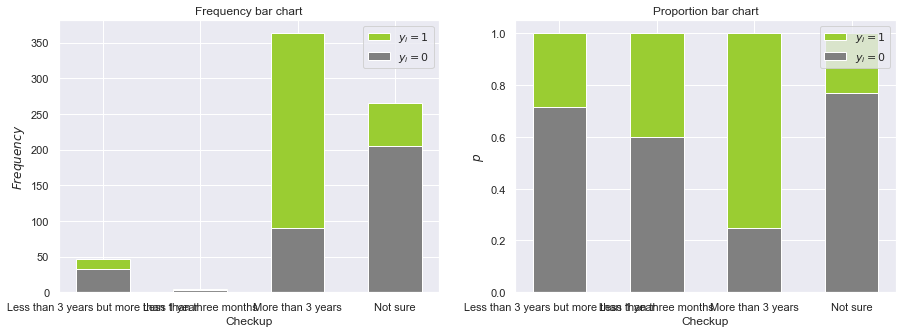

In [81]:
# first join all the training data
all_train = X_train.join(y_train)


def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()
    
bar_charts_categorical(all_train, "Checkup", "Disease")

#Qual a variavel que acham melhor ?

## Wrapper methods



### RFE


In [82]:
model = LogisticRegression()

In [83]:
rfe = RFE(estimator = model, n_features_to_select = 3)

In [84]:
X_rfe = rfe.fit_transform(X = X_train_num_scaled, y = y_train)

In [85]:
rfe.support_

array([False, False, False,  True, False,  True,  True, False, False,
       False])

In [86]:
X_train_num_scaled.columns

Index(['Birth_Year', 'Height', 'Weight', 'High_Cholesterol', 'Blood_Pressure',
       'Mental_Health', 'Physical_Health', 'Age', 'Gender', 'BMI'],
      dtype='object')

In [87]:
rfe.ranking_

array([3, 6, 8, 1, 4, 1, 1, 5, 2, 7])

In [88]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

Birth_Year          False
Height              False
Weight              False
High_Cholesterol     True
Blood_Pressure      False
Mental_Health        True
Physical_Health      True
Age                 False
Gender              False
BMI                 False
dtype: bool

In [96]:
#no of features
nof_list=list(range(1,11)) #How do we choose the range??????
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in nof_list:
    model = LogisticRegression()
    rfe = RFE(estimator = model, n_features_to_select = n)
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_val_rfe,y_val)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 4
Score with 4 features: 0.733333


In [97]:
rfe = RFE(estimator = model, n_features_to_select = 4)
X_rfe = rfe.fit_transform(X = X_train_num_scaled, y = y_train)
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

Birth_Year          False
Height              False
Weight              False
High_Cholesterol     True
Blood_Pressure      False
Mental_Health        True
Physical_Health      True
Age                 False
Gender               True
BMI                 False
dtype: bool

According to RFE, the numerical variables that we should keep for the final model are `High_Cholesterol`, `Mental_Health` and `Physical_Health` and `Gender`.



## Embedded Methods



### Lasso Regression


In [101]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [102]:
reg= LassoCV()

In [103]:
reg.fit(X_train_num_scaled, y_train)

LassoCV()

In [104]:
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)
coef

Birth_Year          0.208364
Height              0.195452
Weight              0.000000
High_Cholesterol   -0.482475
Blood_Pressure     -0.293646
Mental_Health       0.703682
Physical_Health    -0.751089
Age                -0.066993
Gender             -0.421749
BMI                 0.083582
dtype: float64

In [105]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated the other 1 variables


In [106]:
coef.sort_values()

Physical_Health    -0.751089
High_Cholesterol   -0.482475
Gender             -0.421749
Blood_Pressure     -0.293646
Age                -0.066993
Weight              0.000000
BMI                 0.083582
Height              0.195452
Birth_Year          0.208364
Mental_Health       0.703682
dtype: float64

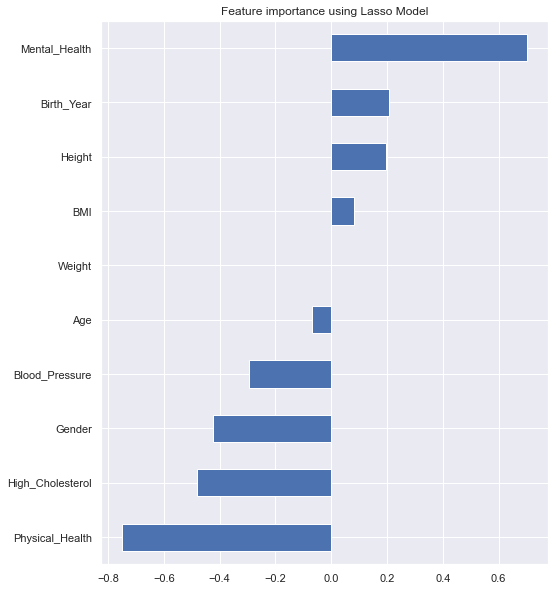

In [107]:
plot_importance(coef,'Lasso')


## Final Insights:



### Numerical Data

| Predictor | Spearman | RFE | Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |--- |
| Birth_Year | Discard | Discard | Keep | Discard |
| Age | Discard | Discard | Discard | Discard |
| Height | Discard | Discard | Keep | Discard |
| Weight | Discard | Discard | Discard | Discard |
| Mental_Health | Discard | Keep | Keep | Keep |
| Blood_Pressure | Discard | Discard | Keep |  Discard |
| High_Cholesterol | Discard | Keep | Keep |  Discard |
| Physical_Health| Discard | Keep | Keep |  Keep |
| Gender | Discard | Keep | Keep |  Keep |
| BMI | Discard | Discard | Discard?? |  Discard |


### Categorical Data

| Predictor | Chi-Square | 
| --- | --- | 
| Name | Discard |  
| Region | Discard | 
| Education | Discard|
| Smoking_Habit | Discard | 
| Drinking_Habit | Keep | 
| Exercise | Keep |
| Fruit_Habit | Keep |
| Water_Habit | Discard |
| Checkup | Keep |
| Diabetes | Keep |